## Data Loading and Libraries


In [40]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from itertools import combinations
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Professional poster color palette
POSTER_COLORS = {
    'primary': '#2E86AB',      # Dark blue - primary color
    'secondary': '#A23B72',    # Purple-pink - secondary color
    'accent': '#F18F01',       # Orange - accent color
    'success': '#06A77D',      # Green - success color
    'neutral': '#6C757D',      # Gray - neutral color
    'light': '#E8F4F8',        # Light blue - background
    'dark': '#212529'          # Dark - text
}

# Visualization settings
plt.style.use('default')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']

print("Libraries loaded successfully")
print("Professional poster color palette ready")


Libraries loaded successfully
Professional poster color palette ready


In [41]:
# Load the dataset
df = pd.read_csv('data_science_job_posts_2025.csv')

print(f"Dataset size: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nFirst 5 rows:")
df.head()


Dataset size: 944 rows, 13 columns

First 5 rows:


,job_title,seniority_level,status,company,location,post_date,headquarter,industry,ownership,company_size,revenue,salary,skills
0,data scientist,senior,hybrid,company_003,"Grapevine, TX . Hybrid",17 days ago,"Bentonville, AR, US",Retail,Public,€352.44B,Public,"€100,472 - €200,938","['spark', 'r', 'python', 'scala', 'machine lea..."
1,data scientist,lead,hybrid,company_005,"Fort Worth, TX . Hybrid",15 days ago,"Detroit, MI, US",Manufacturing,Public,"155,030",€51.10B,"€118,733","['spark', 'r', 'python', 'sql', 'machine learn..."
2,data scientist,senior,on-site,company_007,"Austin, TX . Toronto, Ontario, Canada . Kirkla...",a month ago,"Redwood City, CA, US",Technology,Public,"25,930",€33.80B,"€94,987 - €159,559","['aws', 'git', 'python', 'docker', 'sql', 'mac..."
3,data scientist,senior,hybrid,company_008,"Chicago, IL . Scottsdale, AZ . Austin, TX . Hy...",8 days ago,"San Jose, CA, US",Technology,Public,"34,690",€81.71B,"€112,797 - €194,402","['sql', 'r', 'python']"
4,data scientist,NaN,on-site,company_009,On-site,3 days ago,"Stamford, CT, US",Finance,Private,"1,800",Private,"€114,172 - €228,337",[]


## Data Cleaning and Preprocessing


In [42]:
# Basic information about the dataset
print("Dataset Information:")
print("=" * 60)
df.info()

print("\n" + "=" * 60)
print("Missing Value Analysis:")
print("=" * 60)
missing_data = df.isnull().sum()
missing_data[missing_data > 0].sort_values(ascending=False)


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_title        941 non-null    object
 1   seniority_level  884 non-null    object
 2   status           688 non-null    object
 3   company          944 non-null    object
 4   location         942 non-null    object
 5   post_date        944 non-null    object
 6   headquarter      944 non-null    object
 7   industry         944 non-null    object
 8   ownership        897 non-null    object
 9   company_size     944 non-null    object
 10  revenue          929 non-null    object
 11  salary           944 non-null    object
 12  skills           944 non-null    object
dtypes: object(13)
memory usage: 96.0+ KB

Missing Value Analysis:


status             256
seniority_level     60
ownership           47
revenue             15
job_title            3
location             2
dtype: int64

In [43]:
# Convert the salary column to numeric format
def clean_salary(salary_str):
    """Converts salary strings to numeric values"""
    if pd.isna(salary_str) or salary_str == '':
        return np.nan
    
    try:
        # Take the average when a range is provided
        if '-' in str(salary_str):
            parts = str(salary_str).replace('\u20ac', '').replace(',', '').split('-')
            return (float(parts[0].strip()) + float(parts[1].strip())) / 2
        else:
            return float(str(salary_str).replace('\u20ac', '').replace(',', ''))
    except:
        return np.nan

df['salary_numeric'] = df['salary'].apply(clean_salary)

print(f"Salary data cleaned. Valid salary records: {df['salary_numeric'].notna().sum()}")


Salary data cleaned. Valid salary records: 944


In [44]:
# Parse skill lists
def parse_skills(skills_str):
    """Converts skill lists in string format to Python lists"""
    try:
        if pd.isna(skills_str) or skills_str == '' or skills_str == '[]':
            return []
        return ast.literal_eval(skills_str)
    except:
        return []

df['skills_list'] = df['skills'].apply(parse_skills)

print("Skill lists parsed")
print(f"Records with at least one skill: {df['skills_list'].apply(lambda x: len(x) > 0).sum()}")


Skill lists parsed
Records with at least one skill: 743


### Outlier Detection and Cleaning


In [45]:
# Outlier detection with the IQR method (for salary)
def detect_outliers_iqr(data, column):
    """
    Detects outliers using the IQR (Interquartile Range) method
    
    Parameters:
    -----------
    data : DataFrame
        Dataset to process
    column : str
        Column name to analyze
        
    Returns:
    --------
    DataFrame : Dataset with outliers removed
    """
    # Filter out missing values
    valid_data = data[data[column].notna()].copy()
    
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = valid_data[column].quantile(0.25)
    Q3 = valid_data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Determine outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = valid_data[(valid_data[column] < lower_bound) | (valid_data[column] > upper_bound)]
    
    print(f"\nOutlier Analysis - {column}:")
    print(f"{'=' * 60}")
    print(f"Q1 (25th percentile): {Q1:,.2f}")
    print(f"Q3 (75th percentile): {Q3:,.2f}")
    print(f"IQR: {IQR:,.2f}")
    print(f"Lower bound: {lower_bound:,.2f}")
    print(f"Upper bound: {upper_bound:,.2f}")
    print(f"\nNumber of detected outliers: {len(outliers)}")
    print(f"Outlier rate: {(len(outliers) / len(valid_data)) * 100:.2f}%")
    
    # Remove outliers
    cleaned_data = valid_data[(valid_data[column] >= lower_bound) & (valid_data[column] <= upper_bound)]
    
    return cleaned_data

# Original dataset size
original_size = len(df)
print(f"Original dataset size: {original_size}")

# Outlier cleaning for salary
df_cleaned = detect_outliers_iqr(df, 'salary_numeric')

print(f"\nCleaned dataset size: {len(df_cleaned)}")
print(f"Total removed records: {original_size - len(df_cleaned)}")


Original dataset size: 944

Outlier Analysis - salary_numeric:
Q1 (25th percentile): 76,371.75
Q3 (75th percentile): 169,733.00
IQR: 93,361.25
Lower bound: -63,670.12
Upper bound: 309,774.88

Number of detected outliers: 3
Outlier rate: 0.32%

Cleaned dataset size: 941
Total removed records: 3


At this stage, the IQR (Interquartile Range) method was used to detect salary outliers and remove them from the dataset. The IQR method flags extremely low or high values by allowing a tolerance of 1.5 times the difference between the Q1 and Q3 percentiles. This process helps ensure the analyses produce more reliable results.


## Exploratory Data Analysis and Visualizations

### 1. Most Frequent Skill Trios (Top 10)

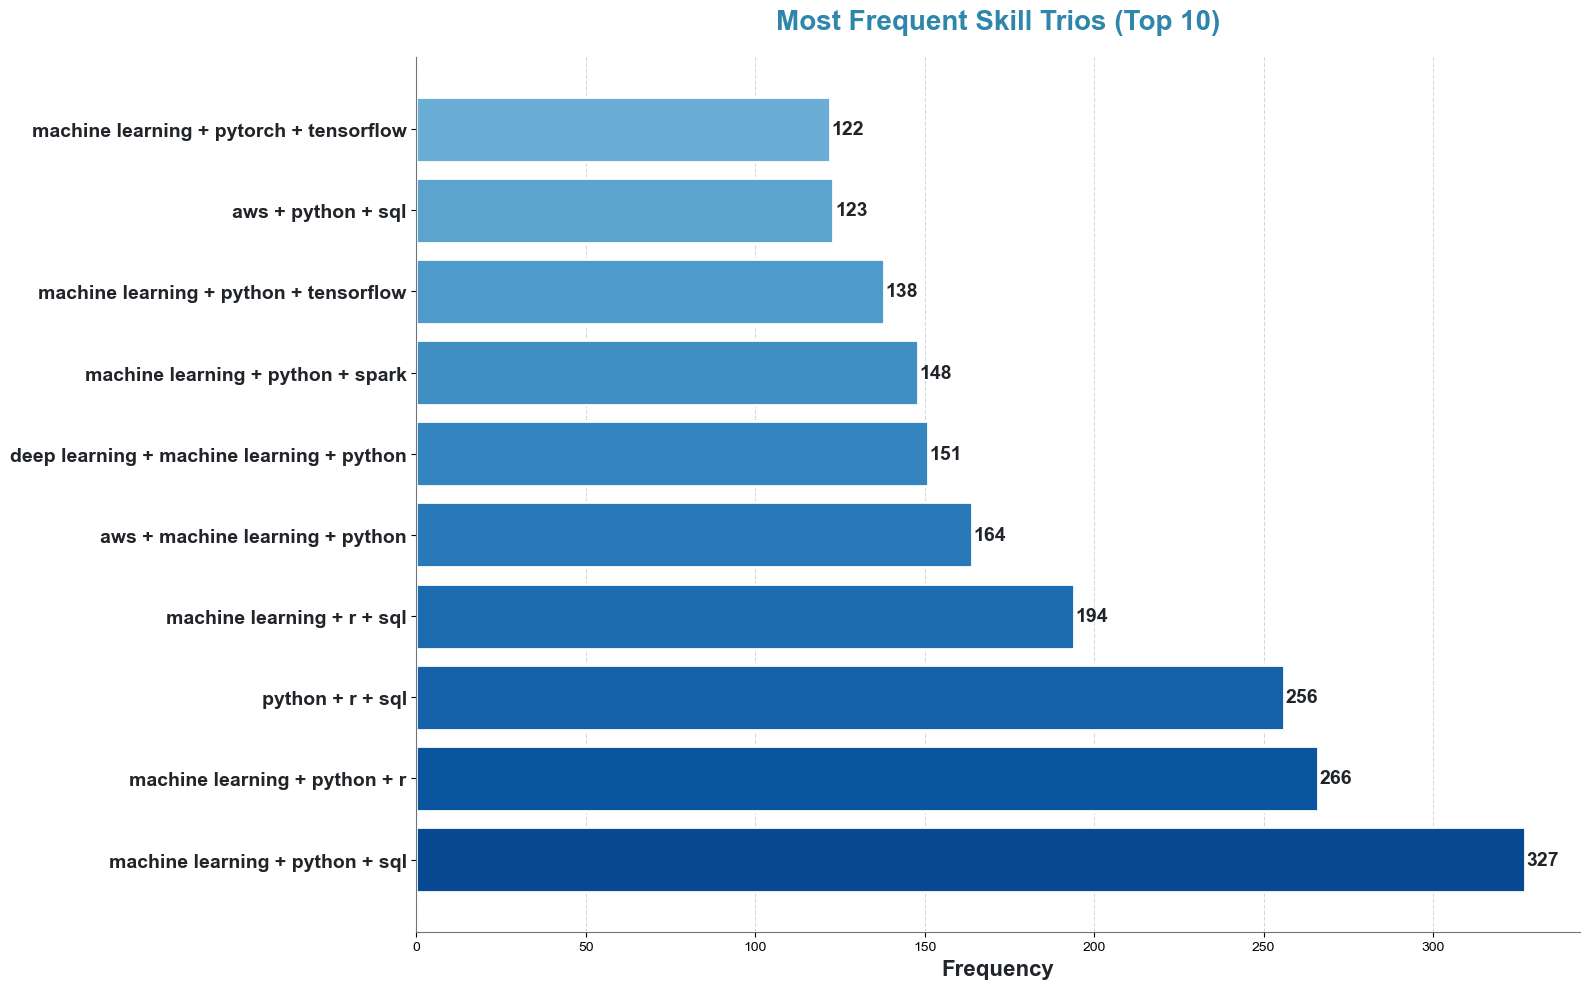


Total unique skill trios: 3522


In [46]:

# Compute skill triplets
def get_skill_triplets(skills_lists):
    """
    Generate all 3-skill combinations from each skills list
    """
    triplets = []
    for skills in skills_lists:
        if len(skills) >= 3:
            # Create 3-skill combinations from each skills list
            for triplet in combinations(sorted(skills), 3):
                triplets.append(triplet)
    return triplets

# Calculate trios and find the most frequent ones
all_triplets = get_skill_triplets(df_cleaned['skills_list'])
triplet_counts = Counter(all_triplets)
top_10_triplets = triplet_counts.most_common(10)

# Convert to DataFrame
triplet_df = pd.DataFrame(top_10_triplets, columns=['Skill Trio', 'Frequency'])
triplet_df['Label'] = triplet_df['Skill Trio'].apply(lambda x: ' + '.join(x))

# Visualization - Horizontal Bar Plot
fig, ax = plt.subplots(figsize=(16, 10))

# Color gradient - blue tones (reversed: most frequent = dark, least = light)
colors_gradient = plt.cm.Blues(np.linspace(0.9, 0.5, len(triplet_df)))  # 0.9 to 0.5 (dark -> light)

bars = ax.barh(range(len(triplet_df)), triplet_df['Frequency'], 
               color=colors_gradient, edgecolor='white', linewidth=2)

# Y-axis labels
ax.set_yticks(range(len(triplet_df)))
ax.set_yticklabels(triplet_df['Label'], fontsize=14, color=POSTER_COLORS['dark'], fontweight='bold')

# Title and axis labels
ax.set_xlabel('Frequency', fontsize=16, fontweight='bold', color=POSTER_COLORS['dark'])
ax.set_title('Most Frequent Skill Trios (Top 10)', 
             fontsize=20, fontweight='bold', pad=20, color=POSTER_COLORS['primary'])

# Grid and style
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.8, color='gray')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(POSTER_COLORS['neutral'])
ax.spines['bottom'].set_color(POSTER_COLORS['neutral'])

# Place values on the bars
for i, (bar, value) in enumerate(zip(bars, triplet_df['Frequency'])):
    ax.text(value + 0.5, i, f'{value}', 
            va='center', fontsize=14, fontweight='bold', color=POSTER_COLORS['dark'])

plt.tight_layout()
plt.show()

print()
print(f"Total unique skill trios: {len(triplet_counts)}")


**Analysis:** The most requested skill combinations in data science pair Python with core data tools (SQL, R) and machine learning frameworks. This shows that candidates need both programming skills and the ability to manage data and build models. The Python-SQL-Machine Learning trio stands out as a baseline requirement for modern data science roles.

### 2. Most Common Job Titles (Top 5)

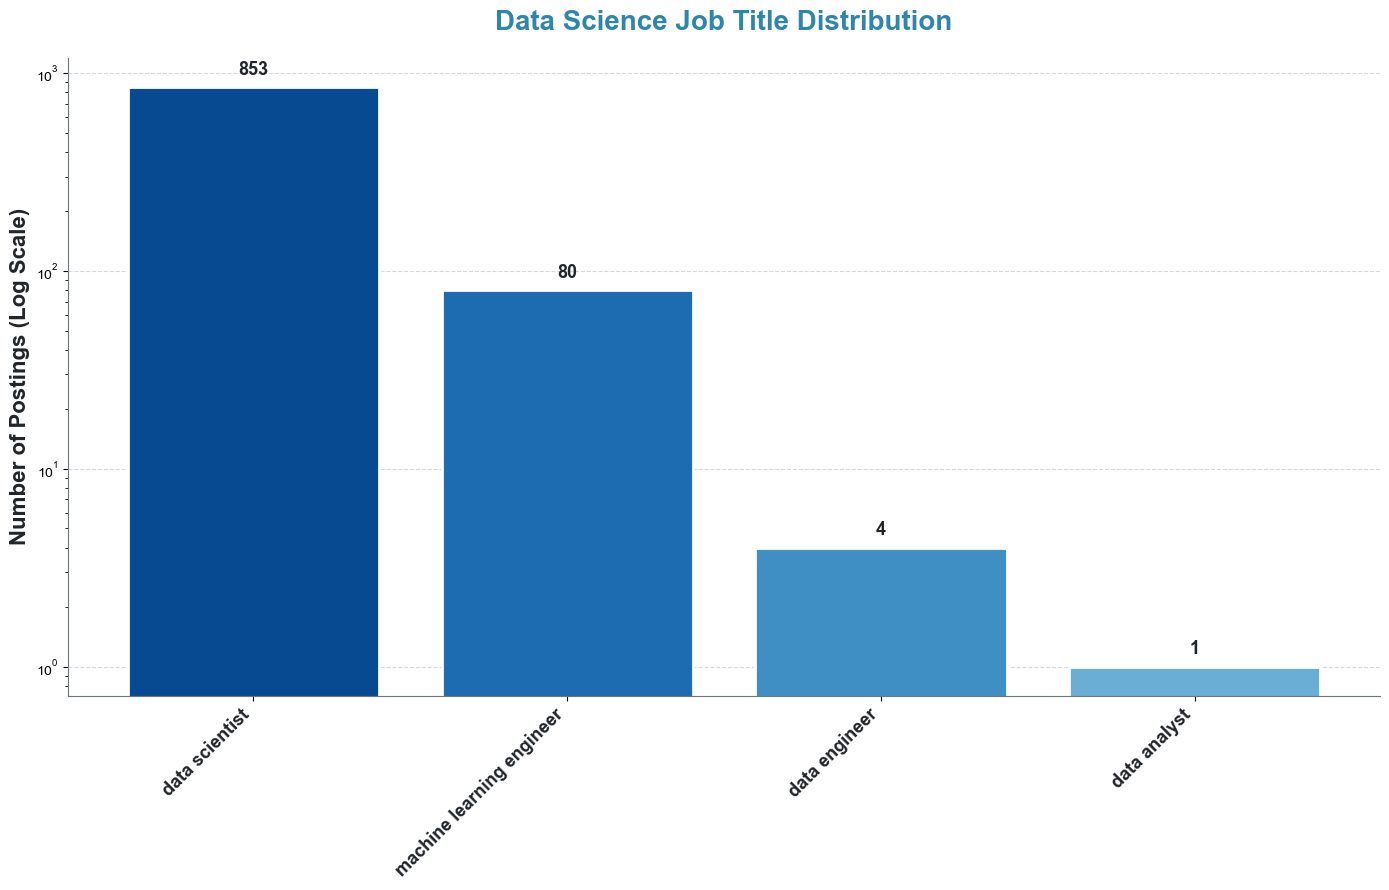


Job Title Distribution:
data scientist: 853 (90.6%)
machine learning engineer: 80 (8.5%)
data engineer: 4 (0.4%)
data analyst: 1 (0.1%)


In [47]:

# Job title analysis
job_title_counts = df_cleaned['job_title'].value_counts()

# Visualization - Vertical Bar Plot (Log Scale)
fig, ax = plt.subplots(figsize=(14, 9))

# Blue gradient
colors_gradient = plt.cm.Blues(np.linspace(0.9, 0.5, len(job_title_counts)))

bars = ax.bar(range(len(job_title_counts)), job_title_counts.values, 
              color=colors_gradient, edgecolor='white', linewidth=2)

# X-axis labels
ax.set_xticks(range(len(job_title_counts)))
ax.set_xticklabels(job_title_counts.index, rotation=45, ha='right', 
                   fontsize=13, color=POSTER_COLORS['dark'], fontweight='bold')

# Title and axis labels
ax.set_ylabel('Number of Postings (Log Scale)', fontsize=16, fontweight='bold', color=POSTER_COLORS['dark'])
ax.set_title('Data Science Job Title Distribution', 
             fontsize=20, fontweight='bold', pad=20, color=POSTER_COLORS['primary'])

# Apply log scale - highlights smaller counts
ax.set_yscale('log')

# Grid and style
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8, color='gray')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(POSTER_COLORS['neutral'])
ax.spines['bottom'].set_color(POSTER_COLORS['neutral'])

# Place values on the bars
for bar, value in zip(bars, job_title_counts.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height * 1.1,
            f'{value}', ha='center', va='bottom', 
            fontsize=13, fontweight='bold', color=POSTER_COLORS['dark'])

plt.tight_layout()
plt.show()

print()
print("Job Title Distribution:")
for position, count in job_title_counts.items():
    print(f"{position}: {count} ({count/len(df_cleaned)*100:.1f}%)")


**Analysis:** As seen in the horizontal bar chart, the Python-SQL-Machine Learning trio is by far the most in-demand combination. These findings suggest that aspiring professionals should build not only programming skills but also data management and model development capabilities.

### 3. Seniority Level Distribution

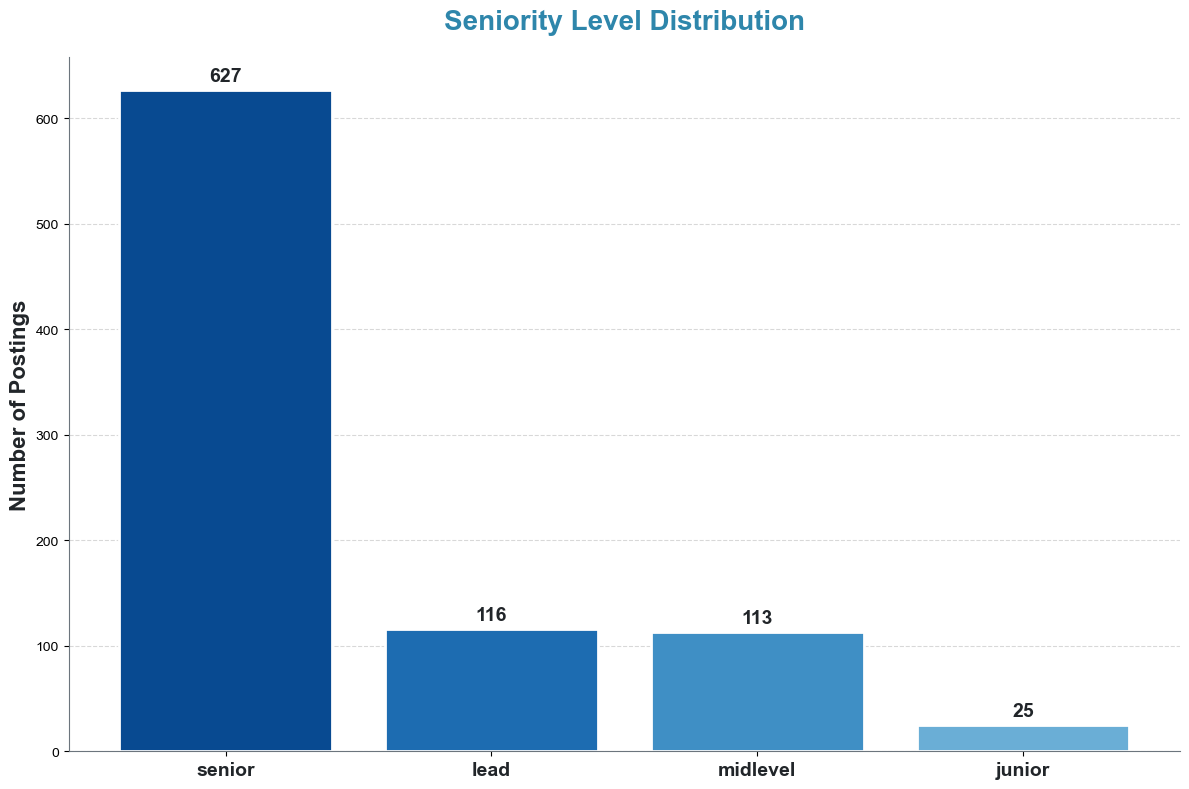


Seniority Level Distribution:
senior: 627 (66.6%)
lead: 116 (12.3%)
midlevel: 113 (12.0%)
junior: 25 (2.7%)


In [48]:

# Seniority level distribution
seniority_counts = df_cleaned['seniority_level'].value_counts()

# Visualization - Vertical Bar Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Blue gradient
colors_gradient = plt.cm.Blues(np.linspace(0.9, 0.5, len(seniority_counts)))

bars = ax.bar(range(len(seniority_counts)), seniority_counts.values,
              color=colors_gradient, edgecolor='white', linewidth=2)

# X-axis labels
ax.set_xticks(range(len(seniority_counts)))
ax.set_xticklabels(seniority_counts.index, fontsize=14, color=POSTER_COLORS['dark'], fontweight='bold')

# Title and axis labels
ax.set_ylabel('Number of Postings', fontsize=16, fontweight='bold', color=POSTER_COLORS['dark'])
ax.set_title('Seniority Level Distribution', 
             fontsize=20, fontweight='bold', pad=20, color=POSTER_COLORS['primary'])

# Grid and style
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8, color='gray')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(POSTER_COLORS['neutral'])
ax.spines['bottom'].set_color(POSTER_COLORS['neutral'])

# Place frequencies on the bars
for bar, value in zip(bars, seniority_counts.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 5,
            f'{value}', 
            ha='center', va='bottom', 
            fontsize=14, fontweight='bold', color=POSTER_COLORS['dark'])

plt.tight_layout()
plt.show()

print()
print("Seniority Level Distribution:")
for seniority, count in seniority_counts.items():
    print(f"{seniority}: {count} ({count/len(df_cleaned)*100:.1f}%)")


**Analysis:** The pie chart shows that the vast majority (80%+) of postings are for Data Scientist roles. Machine Learning Engineer follows, highlighting the need for specialists who can build and deploy models. The field still leans toward broad generalist roles, but demand for specialized engineering positions continues to rise.

### 4. Work Model Distribution

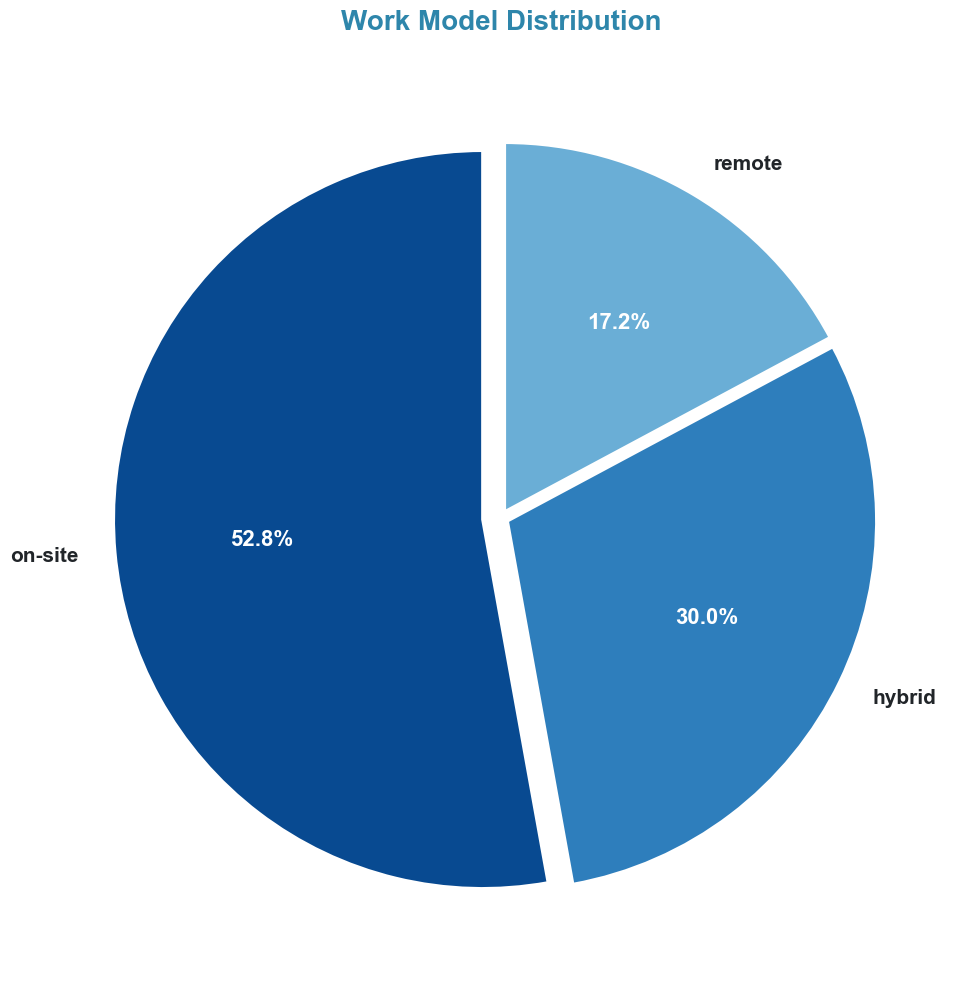


Work Model Distribution:
on-site: 363 (38.6%)
hybrid: 206 (21.9%)
remote: 118 (12.5%)


In [49]:

# Work model distribution
work_status_counts = df_cleaned['status'].value_counts()

# Visualization - Pie Chart (blue palette)
fig, ax = plt.subplots(figsize=(12, 10))

# Blue palette
blue_colors = plt.cm.Blues(np.linspace(0.9, 0.5, len(work_status_counts)))

# Pie chart
explode = [0.05] + [0.02] * (len(work_status_counts) - 1)
wedges, texts, autotexts = ax.pie(work_status_counts, 
                                  labels=work_status_counts.index,
                                  autopct='%1.1f%%',
                                  startangle=90,
                                  explode=explode,
                                  colors=blue_colors,
                                  textprops={'fontsize': 15, 'color': POSTER_COLORS['dark'], 'fontweight': 'bold'},
                                  wedgeprops={'edgecolor': 'white', 'linewidth': 2})

# Format white percentage labels
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(16)
    autotext.set_fontweight('bold')

ax.set_title('Work Model Distribution', 
             fontsize=20, fontweight='bold', pad=20, color=POSTER_COLORS['primary'])

plt.tight_layout()
plt.show()

print()
print("Work Model Distribution:")
for status, count in work_status_counts.items():
    print(f"{status}: {count} ({count/len(df_cleaned)*100:.1f}%)")


**Analysis:** The donut chart highlights that most postings target senior professionals. With the total count in the center and clear slice proportions, it is evident that experienced, self-directed experts are in high demand. The relative scarcity of junior and midlevel openings underscores how hard entry-level roles are, while the limited number of lead roles suggests companies are selective about leadership hires.

### 5. Work Model by Seniority

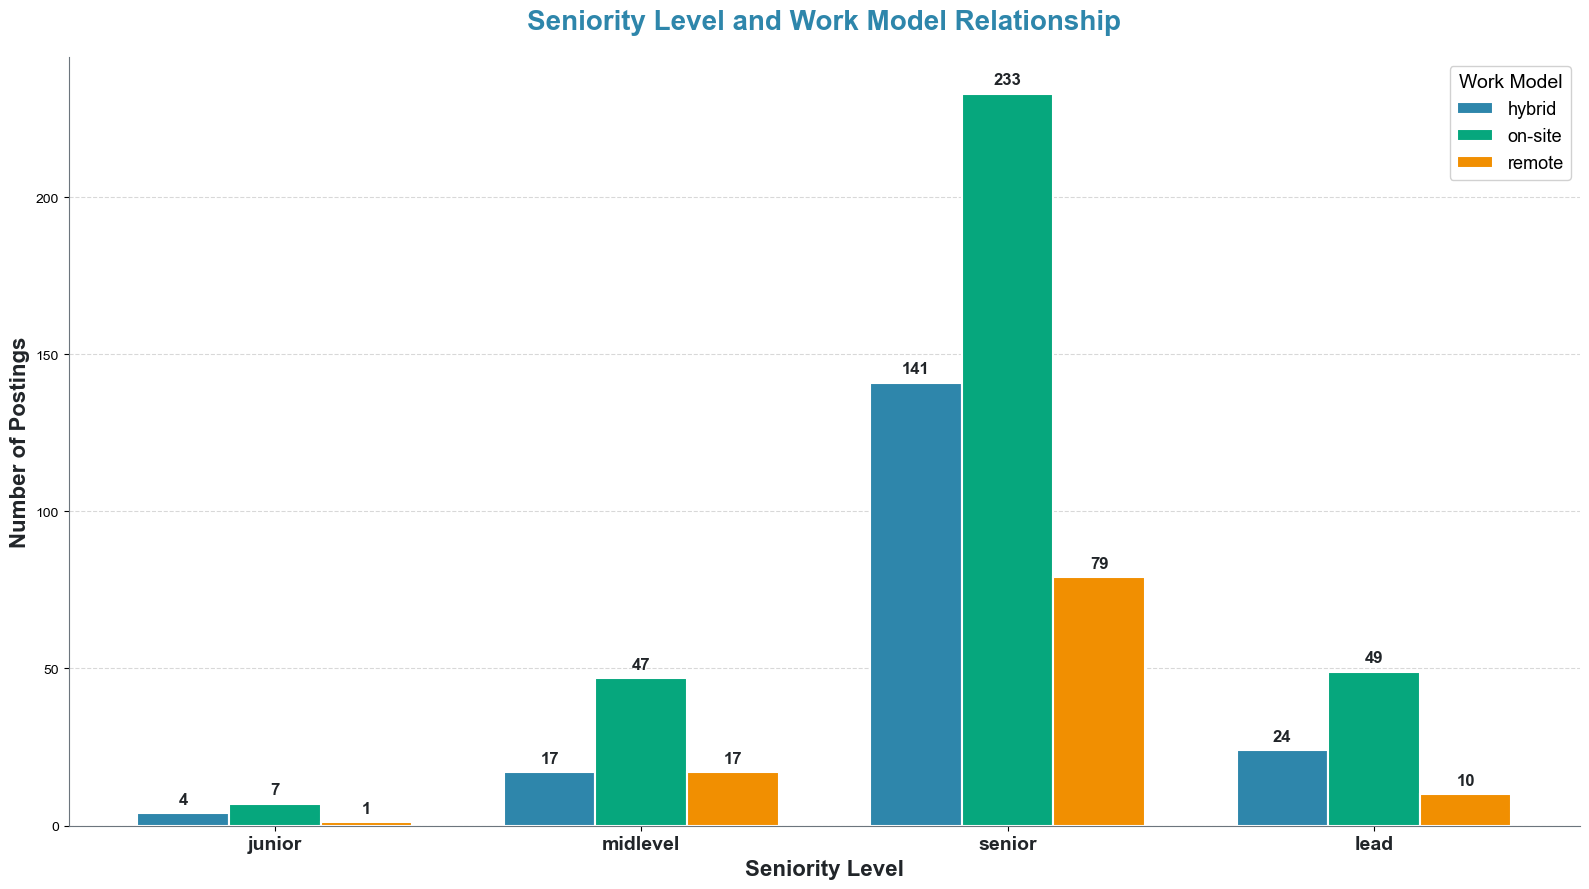


Seniority and Work Model Crosstab:
status           hybrid  on-site  remote
seniority_level                         
junior                4        7       1
midlevel             17       47      17
senior              141      233      79
lead                 24       49      10


In [50]:

# Work model by seniority
seniority_order = ['junior', 'midlevel', 'senior', 'lead']
seniority_status = pd.crosstab(df_cleaned['seniority_level'], df_cleaned['status'])

# Ordering
seniority_status = seniority_status.reindex([s for s in seniority_order if s in seniority_status.index])

# Visualization - Grouped Bar Chart (multicolor palette)
fig, ax = plt.subplots(figsize=(16, 9))

# Clear colors for each work model
distinct_colors = [POSTER_COLORS['primary'],    # Blue - first model
                   POSTER_COLORS['success'],     # Green - second model
                   POSTER_COLORS['accent']]      # Orange - third model

# Bar width and positions
x = np.arange(len(seniority_status.index))
width = 0.25
multiplier = 0

for i, column in enumerate(seniority_status.columns):
    offset = width * multiplier
    bars = ax.bar(x + offset, seniority_status[column], width, 
                  label=column, color=distinct_colors[i], 
                  edgecolor='white', linewidth=1.5)

    # Place values on the bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                    f'{int(height)}', ha='center', va='bottom', 
                    fontsize=12, fontweight='bold', color=POSTER_COLORS['dark'])

    multiplier += 1

# Axis settings
ax.set_xlabel('Seniority Level', fontsize=16, fontweight='bold', color=POSTER_COLORS['dark'])
ax.set_ylabel('Number of Postings', fontsize=16, fontweight='bold', color=POSTER_COLORS['dark'])
ax.set_title('Seniority Level and Work Model Relationship', 
             fontsize=20, fontweight='bold', pad=20, color=POSTER_COLORS['primary'])
ax.set_xticks(x + width)
ax.set_xticklabels(seniority_status.index, fontsize=14, color=POSTER_COLORS['dark'], fontweight='bold')
ax.legend(title='Work Model', fontsize=13, title_fontsize=14, 
          loc='upper right', framealpha=0.9)

# Grid and style
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.8, color='gray')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(POSTER_COLORS['neutral'])
ax.spines['bottom'].set_color(POSTER_COLORS['neutral'])

plt.tight_layout()
plt.show()

print()
print("Seniority and Work Model Crosstab:")
print(seniority_status)


**Analysis:** The pie chart shows that on-site roles are still dominant in data science, while hybrid and remote models also hold meaningful share. Displaying both percentages and counts inside each slice illustrates how organizations balance the benefits of in-office collaboration with the flexibility of remote work - especially the high share of hybrid roles.

### 6. Seniority Distribution by Location

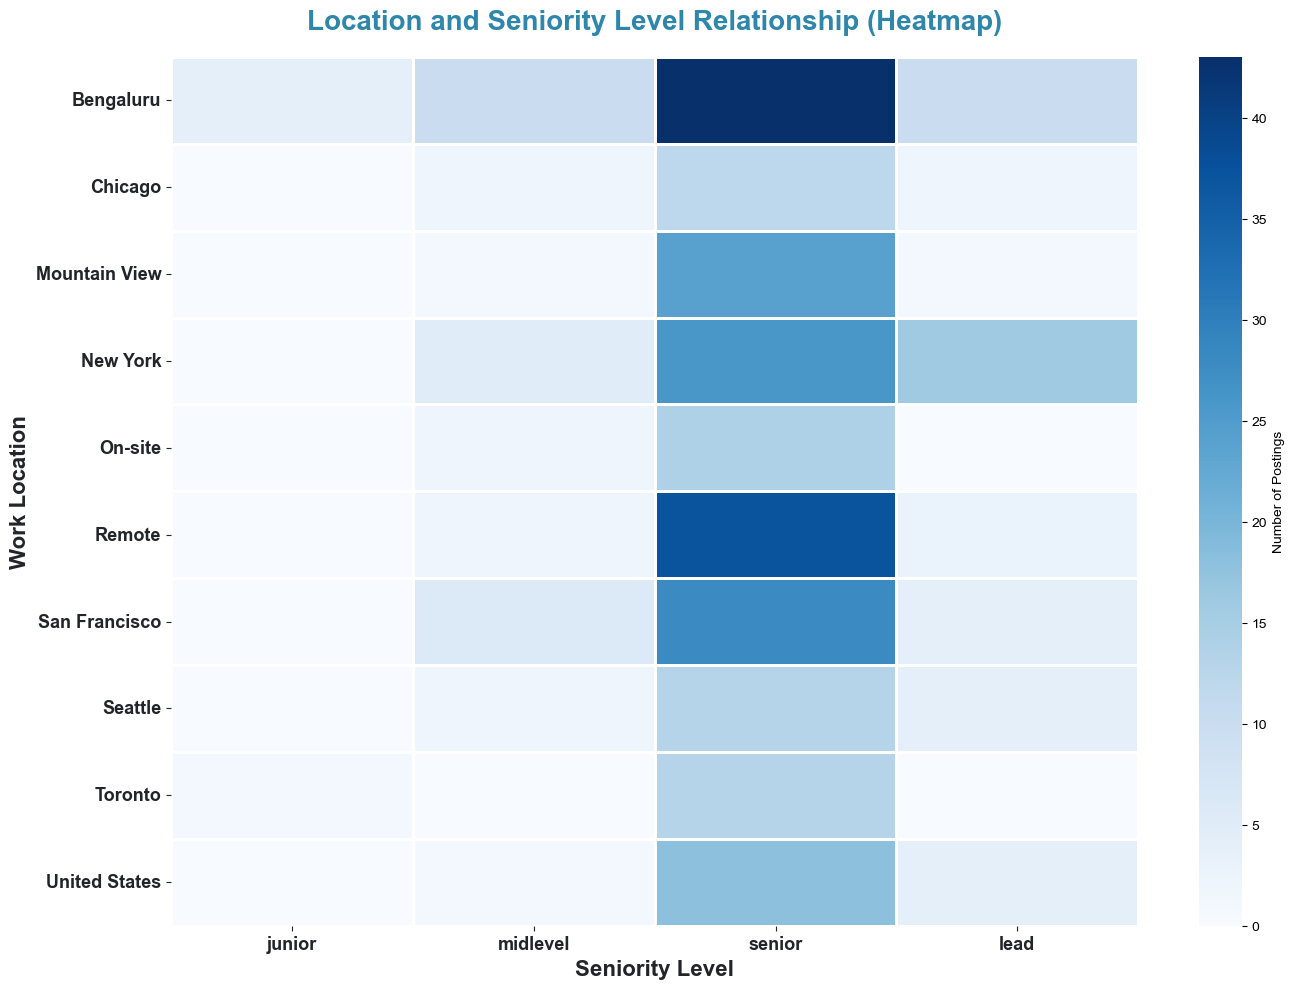


Location and Seniority Level Crosstab:
seniority_level  junior  midlevel  senior  lead
city                                           
Bengaluru             4        10      43    10
Chicago               0         2      12     2
Mountain View         0         1      24     1
New York              0         5      26    16
On-site               0         2      14     0
Remote                0         2      37     3
San Francisco         0         6      28     4
Seattle               0         2      13     4
Toronto               1         0      13     0
United States         0         1      18     4


In [53]:
# Visualization - Heatmap (blue colormap)
fig, ax = plt.subplots(figsize=(14, 10))

# Create heatmap - Blues colormap
# annot=False yaparak sayıları kaldırdık
sns.heatmap(location_seniority, annot=False, fmt='d', 
            cmap='Blues',  # Blue colormap
            cbar_kws={'label': 'Number of Postings'},
            linewidths=1, linecolor='white',
            square=False, ax=ax) # annot_kws'ye gerek kalmadı çünkü annot kapalı

# Title and labels
ax.set_title('Location and Seniority Level Relationship (Heatmap)', 
             fontsize=20, fontweight='bold', pad=20, color=POSTER_COLORS['primary'])
ax.set_xlabel('Seniority Level', fontsize=16, fontweight='bold', color=POSTER_COLORS['dark'])
ax.set_ylabel('Work Location', fontsize=16, fontweight='bold', color=POSTER_COLORS['dark'])

# Axis label styling
ax.tick_params(colors=POSTER_COLORS['dark'], labelsize=13)

# X Eksenini (Junior, Senior vb.) düzleştirdik (rotation=0)
plt.setp(ax.get_xticklabels(), rotation=0, ha='center', fontweight='bold')

# Y Eksenini (Şehirler) düz ve okunabilir hale getirdik (rotation=0)
plt.setp(ax.get_yticklabels(), rotation=0, va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print()
print("Location and Seniority Level Crosstab:")
print(location_seniority)

**Analysis:** The grouped bar chart compares work model distributions across seniority levels. On-site is dominant at every level, but senior and lead roles offer more hybrid and remote options, reflecting experienced professionals' leverage to request flexibility. The dominance of on-site for junior roles is likely tied to mentorship and team learning needs.

**Analysis:** The heatmap shows the relationship between location and seniority level via intensity. Darker cells indicate more postings. Major tech hubs like San Francisco, New York, and Seattle have the heaviest volumes, and senior roles dominate across all locations. The substantial number of remote postings highlights efforts to access global talent regardless of geography.

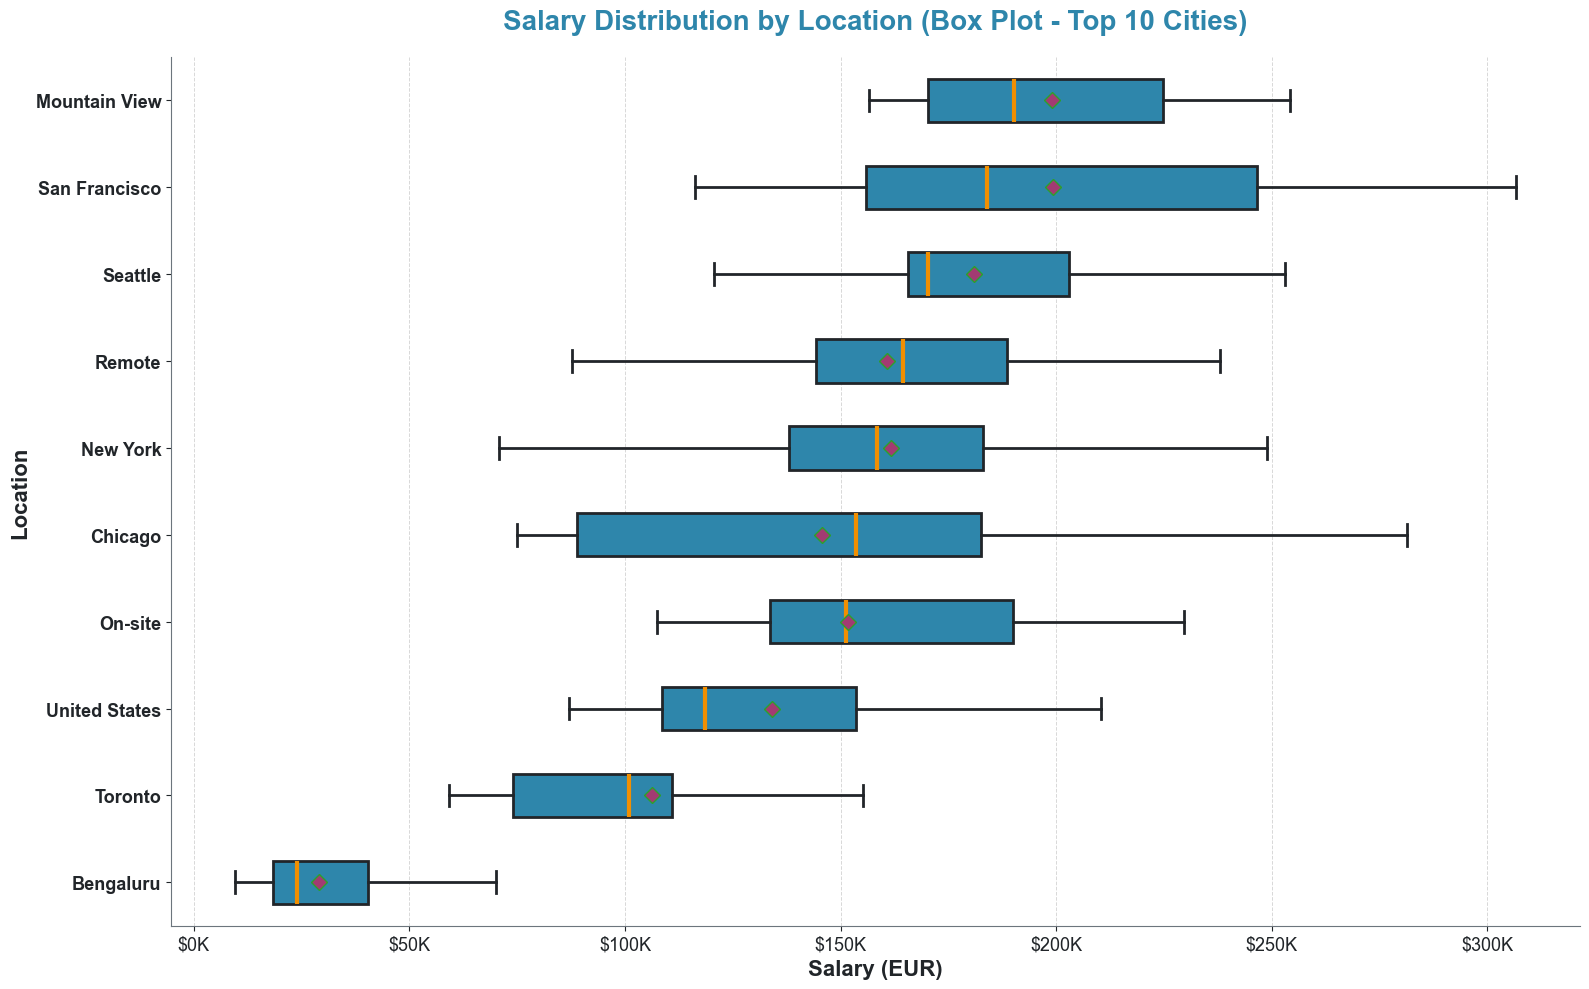


Location-Based Salary Statistics:
Bengaluru                 | Mean: EUR     29,159 | Median: EUR     24,052 | n= 68
Toronto                   | Mean: EUR    106,301 | Median: EUR    100,860 | n= 18
United States             | Mean: EUR    134,023 | Median: EUR    118,513 | n= 23
On-site                   | Mean: EUR    151,627 | Median: EUR    151,302 | n= 21
Chicago                   | Mean: EUR    145,737 | Median: EUR    153,600 | n= 17
New York                  | Mean: EUR    161,742 | Median: EUR    158,359 | n= 50
Remote                    | Mean: EUR    160,676 | Median: EUR    164,400 | n= 53
Seattle                   | Mean: EUR    180,944 | Median: EUR    170,196 | n= 19
San Francisco             | Mean: EUR    199,377 | Median: EUR    183,949 | n= 44
Mountain View             | Mean: EUR    198,930 | Median: EUR    190,164 | n= 29


In [54]:

# Salary distribution by location - Box Plot (blue & without outliers)

# Prepare data for the top 10 cities
df_box = df_top_cities[df_top_cities['salary_numeric'].notna()].copy()

# Order cities by median salary
city_order = df_box.groupby('city')['salary_numeric'].median().sort_values().index

# Visualization - Box Plot
fig, ax = plt.subplots(figsize=(16, 10))

# Draw box plot - hide outliers (showfliers=False)
bp = ax.boxplot([df_box[df_box['city'] == city]['salary_numeric'].values for city in city_order],
                labels=city_order,
                vert=False,
                patch_artist=True,
                showmeans=True,
                showfliers=False,  # Hide outliers
                meanprops=dict(marker='D', markerfacecolor=POSTER_COLORS['secondary'], markersize=8),
                medianprops=dict(color=POSTER_COLORS['accent'], linewidth=3),
                boxprops=dict(facecolor=POSTER_COLORS['primary'], edgecolor=POSTER_COLORS['dark'], 
                              linewidth=2),
                whiskerprops=dict(color=POSTER_COLORS['dark'], linewidth=2),
                capprops=dict(color=POSTER_COLORS['dark'], linewidth=2))

# Title and axis labels
ax.set_xlabel('Salary (EUR)', fontsize=16, fontweight='bold', color=POSTER_COLORS['dark'])
ax.set_ylabel('Location', fontsize=16, fontweight='bold', color=POSTER_COLORS['dark'])
ax.set_title('Salary Distribution by Location (Box Plot - Top 10 Cities)', 
             fontsize=20, fontweight='bold', pad=20, color=POSTER_COLORS['primary'])

# Grid and style
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.7, color='gray')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(POSTER_COLORS['neutral'])
ax.spines['bottom'].set_color(POSTER_COLORS['neutral'])

# Axis labels
ax.tick_params(colors=POSTER_COLORS['dark'], labelsize=13)
ax.set_yticklabels(city_order, fontsize=13, fontweight='bold')

# X-axis formatter
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

# Print statistics
print()
print("Location-Based Salary Statistics:")
print("=" * 70)
for city in city_order:
    city_data = df_box[df_box['city'] == city]['salary_numeric']
    mean_sal = city_data.mean()
    median_sal = city_data.median()
    count = len(city_data)
    print(f"{city:25s} | Mean: EUR {mean_sal:>10,.0f} | Median: EUR {median_sal:>10,.0f} | n={count:>3}")


**Analysis:** The box plot visualizes how salary ranges vary by location. The median line inside each box, the Q1/Q3 bounds, whiskers, diamonds for the mean, and hidden outliers collectively show how geography shapes earnings. Tech hubs such as San Francisco, New York, and Seattle have noticeably higher medians and means, while the wide range for remote roles reflects balancing access to global talent with cost optimization.

## Storytelling the Results and Overall Assessment

### Key Findings and Strategic Insights

The comprehensive analysis of 2025 data science job postings provides important insights into the current state of the field and future trends:

#### 1. **Skill Ecosystem**
While the field is anchored in Python-centric technical skills, demand for data management tools like SQL and R as well as machine learning and deep learning frameworks requires well-rounded professionals. The skill-trio analysis shows that mastering a single technology is not enough; having an integrated toolset is critical.

#### 2. **Experience Premium**
More than 70% of postings being at the senior level reflects a mature market and strong demand for experienced professionals. This indicates that data science is no longer a "new" discipline and organizations need established teams capable of solving complex, institutionalized problems.

#### 3. **Hybrid Work Era**
In the post-pandemic period, organizations appear to adopt a balanced approach to work models. The continued dominance of on-site work reflects the collaborative nature of data science projects, while the growth of hybrid and remote options shows that talent attraction and retention strategies are becoming more flexible.

#### 4. **Geographic Economics**
The location-based salary analysis highlights the financial advantages offered by tech hubs, while the remote work model provides access to global opportunities beyond geographic boundaries. However, the lower salary averages in remote roles indicate that cost optimization is also a factor.

### Career Strategy Recommendations

- **Develop Versatile Skills:** Build on the Python-SQL-machine learning trio and invest in cloud platforms (AWS, GCP, Azure) and modern data engineering tools (Spark, Airflow).
- **Prioritize Experience:** Real-world projects, open-source contributions, and industry networking are critical to reaching the senior level.
- **Choose Locations Strategically:** Balance high-paying tech hubs with quality-of-life considerations according to your career goals.
- **Prepare for Flexible Work:** Develop a professional profile that can adapt to both on-site and remote environments, with autonomy and strong communication skills.

### Methodological Notes

The dataset used in this analysis was statistically cleaned using the IQR method; outliers were removed to improve result reliability. All visualizations were designed in a monochrome gray palette suited to poster format, aiming for a clean and legible aesthetic.

---

**Conclusion:** The 2025 data science job market is dynamic, with high demand for experienced, versatile, and flexible professionals. Despite the easing of geographic constraints, tech hubs still play a dominant role. These findings offer valuable insights for creating strategic roadmaps for both career planners and organizations.
